In [1]:
import os 

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")

In [3]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# 메타데이터를 불러와 특정 배터리 그룹을 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)
battery_ids = ["B0005", "B0006", "B0007", "B0018"]

print("=" * 70)
print("배터리 그룹 1 (B0005, B0006, B0007, B0018) 데이터 로드")
print("=" * 70)

# 각 배터리별 메타데이터 수집
group_meta_dict = {}
for battery_id in battery_ids:
    battery_meta = (
        meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
        .sort_values("start_time")
        .reset_index(drop=True)
    )
    battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
    battery_meta["cycle_index"] = np.arange(len(battery_meta))
    battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]
    group_meta_dict[battery_id] = battery_meta
    print(f"\n{battery_id}: {len(battery_meta)}개 사이클")
    display(battery_meta[["type", "cycle_index", "soh"]].head(3))

배터리 그룹 1 (B0005, B0006, B0007, B0018) 데이터 로드

B0005: 168개 사이클


,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.016818
2,discharge,2,1.011254



B0006: 168개 사이클


,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.057732
2,discharge,2,1.052433



B0007: 168개 사이클


,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.010713
2,discharge,2,1.005146



B0018: 132개 사이클


,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,0.967036
2,discharge,2,0.927085


In [6]:
# 공통 설정
WINDOW_SIZE = 3
BATCH_SIZE = 16
EPOCHS = 50
TRAIN_RATIO = 0.8

FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

# 각 배터리별 SEQ_LEN 결정: 배터리별 CSV 파일 중 최소 길이 찾기
print("\n" + "=" * 70)
print("각 배터리별 SEQ_LEN 자동 결정 중...")
print("=" * 70)

battery_seq_lens = {}

for battery_id in battery_ids:
    battery_meta = group_meta_dict[battery_id]
    min_len = float('inf')
    
    # 해당 배터리의 모든 CSV 파일 길이 확인
    for filename in battery_meta["filename"]:
        file_path = DATA_ROOT / "data" / filename
        df = pd.read_csv(file_path)
        min_len = min(min_len, len(df))
    
    battery_seq_lens[battery_id] = min_len
    print(f"{battery_id}: 최소 CSV 길이 = {min_len}")

print(f"\n✅ 배터리별 SEQ_LEN 설정 완료")
print("=" * 70)

# 배터리별 데이터 로드 함수
def load_cycle_sequence(filename: str, battery_id: str) -> np.ndarray:
    """원본 csv를 배터리별 고정 길이로 리샘플링"""
    seq_len = battery_seq_lens[battery_id]
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

# 윈도우 생성 함수
def create_sequence_windows(sequences, targets, window_size):
    """시계열 윈도우 생성"""
    X_windows = []
    y_windows = []
    for i in range(len(sequences) - window_size):
        window = sequences[i:i+window_size]
        target = targets[i+window_size]
        X_windows.append(window)
        y_windows.append(target)
    return np.array(X_windows), np.array(y_windows)

print("\n함수 정의 완료")
print(f"배터리별 시퀀스 길이: {battery_seq_lens}")
print(f"윈도우 크기 (WINDOW_SIZE): {WINDOW_SIZE}")
print(f"특성 개수: {len(FEATURE_COLS)}")


각 배터리별 SEQ_LEN 자동 결정 중...
B0005: 최소 CSV 길이 = 179
B0006: 최소 CSV 길이 = 179
B0007: 최소 CSV 길이 = 179
B0018: 최소 CSV 길이 = 200

✅ 배터리별 SEQ_LEN 설정 완료

함수 정의 완료
배터리별 시퀀스 길이: {'B0005': 179, 'B0006': 179, 'B0007': 179, 'B0018': 200}
윈도우 크기 (WINDOW_SIZE): 3
특성 개수: 5


In [8]:
# 배터리별 개별 데이터 준비
print("\n" + "=" * 70)
print("배터리별 개별 시퀀스 데이터 로드")
print("=" * 70)

battery_data = {}

for battery_id in battery_ids:
    battery_meta = group_meta_dict[battery_id]
    sequences = np.stack(
        [load_cycle_sequence(fn, battery_id) for fn in battery_meta["filename"]], axis=0
    )
    targets = battery_meta["soh"].values
    
    battery_data[battery_id] = {
        'sequences': sequences,
        'targets': targets,
        'seq_len': battery_seq_lens[battery_id]
    }
    
    print(f"{battery_id}: 시퀀스 {sequences.shape}, 타겟 {targets.shape}, SEQ_LEN={battery_seq_lens[battery_id]}")

print(f"\n✅ 배터리별 데이터 준비 완료")


배터리별 개별 시퀀스 데이터 로드
B0005: 시퀀스 (168, 179, 5), 타겟 (168,), SEQ_LEN=179
B0006: 시퀀스 (168, 179, 5), 타겟 (168,), SEQ_LEN=179
B0007: 시퀀스 (168, 179, 5), 타겟 (168,), SEQ_LEN=179
B0018: 시퀀스 (132, 200, 5), 타겟 (132,), SEQ_LEN=200

✅ 배터리별 데이터 준비 완료


In [9]:
# LSTM 회귀 모델 정의
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

# Instant Model용 Dataset
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

# Trend Model용 Dataset
class WindowDataset(Dataset):
    def __init__(self, windows: np.ndarray, targets: np.ndarray):
        N, W, S, F = windows.shape
        self.x = torch.from_numpy(windows.reshape(N, W * S, F))
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

print(f"사용 디바이스: {device}")
print("모델 및 Dataset 클래스 정의 완료")

사용 디바이스: cpu
모델 및 Dataset 클래스 정의 완료


In [10]:
# 학습 함수
def train_model(model, train_loader, val_loader, optimizer, epochs=EPOCHS, patience=10):
    """모델 학습 함수"""
    history = {"train_loss": [], "val_loss": []}
    best_val = float("inf")
    best_state = None
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        # 학습
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        
        # 검증
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        
        if val_loss < best_val:
            best_val = val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if epoch % 10 == 0 or epoch == 1:
            print(f"  Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
        
        if patience_counter >= patience:
            print(f"  Early stopping at epoch {epoch}")
            break
    
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return history, best_val

# 예측 함수
def predict_dataset(model, loader):
    """모델 예측 함수"""
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

print("학습 및 예측 함수 정의 완료")

학습 및 예측 함수 정의 완료


In [11]:
# 배터리별 모델 학습 및 성능 비교
print("\n" + "=" * 80)
print("배터리별 Instant vs Trend 모델 학습 및 비교")
print("=" * 80)

results = {}

for battery_id in battery_ids:
    print(f"\n{'='*80}")
    print(f"🔋 {battery_id} 분석 시작")
    print(f"{'='*80}")
    
    sequences = battery_data[battery_id]['sequences']
    targets = battery_data[battery_id]['targets']
    seq_len = battery_data[battery_id]['seq_len']
    
    # ================================================================
    # Instant Model 준비
    # ================================================================
    print(f"\n[Instant Model - {battery_id}]")
    
    instant_split_idx = int(len(sequences) * TRAIN_RATIO)
    instant_train_X = sequences[:instant_split_idx]
    instant_val_X = sequences[instant_split_idx:]
    instant_train_y = targets[:instant_split_idx]
    instant_val_y = targets[instant_split_idx:]
    
    # 정규화
    flat_train = instant_train_X.reshape(-1, len(FEATURE_COLS))
    instant_mean = flat_train.mean(axis=0)
    instant_std = flat_train.std(axis=0) + 1e-6
    instant_train_X_norm = ((instant_train_X - instant_mean) / instant_std).astype(np.float32)
    instant_val_X_norm = ((instant_val_X - instant_mean) / instant_std).astype(np.float32)
    
    # Dataset 생성
    instant_train_dataset = CycleDataset(instant_train_X_norm, instant_train_y)
    instant_val_dataset = CycleDataset(instant_val_X_norm, instant_val_y)
    instant_train_loader = DataLoader(instant_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    instant_val_loader = DataLoader(instant_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"학습 데이터: {len(instant_train_dataset)}개, 검증 데이터: {len(instant_val_dataset)}개")
    
    # 모델 학습
    instant_model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)
    instant_optimizer = torch.optim.Adam(instant_model.parameters(), lr=1e-3)
    instant_history, instant_best_val = train_model(
        instant_model, instant_train_loader, instant_val_loader, instant_optimizer
    )
    
    # 예측
    instant_preds, instant_targets = predict_dataset(instant_model, instant_val_loader)
    
    # ================================================================
    # Trend Model 준비
    # ================================================================
    print(f"\n[Trend Model - {battery_id}]")
    
    X_windows, y_windows = create_sequence_windows(sequences, targets, WINDOW_SIZE)
    trend_split_idx = int(len(X_windows) * TRAIN_RATIO)
    
    trend_train_X = X_windows[:trend_split_idx]
    trend_val_X = X_windows[trend_split_idx:]
    trend_train_y = y_windows[:trend_split_idx]
    trend_val_y = y_windows[trend_split_idx:]
    
    # 정규화
    trend_train_X_flat = trend_train_X.reshape(-1, seq_len, len(FEATURE_COLS))
    flat_features = trend_train_X_flat.reshape(-1, len(FEATURE_COLS))
    trend_mean = flat_features.mean(axis=0)
    trend_std = flat_features.std(axis=0) + 1e-6
    trend_train_X_norm = ((trend_train_X - trend_mean) / trend_std).astype(np.float32)
    trend_val_X_norm = ((trend_val_X - trend_mean) / trend_std).astype(np.float32)
    
    # Dataset 생성
    trend_train_dataset = WindowDataset(trend_train_X_norm, trend_train_y)
    trend_val_dataset = WindowDataset(trend_val_X_norm, trend_val_y)
    trend_train_loader = DataLoader(trend_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    trend_val_loader = DataLoader(trend_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    print(f"학습 데이터: {len(trend_train_dataset)}개, 검증 데이터: {len(trend_val_dataset)}개")
    
    # 모델 학습
    trend_model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)
    trend_optimizer = torch.optim.Adam(trend_model.parameters(), lr=1e-3)
    trend_history, trend_best_val = train_model(
        trend_model, trend_train_loader, trend_val_loader, trend_optimizer
    )
    
    # 예측
    trend_preds, trend_targets = predict_dataset(trend_model, trend_val_loader)
    
    # ================================================================
    # 성능 평가
    # ================================================================
    instant_mae = mean_absolute_error(instant_targets, instant_preds)
    instant_rmse = np.sqrt(mean_squared_error(instant_targets, instant_preds))
    instant_r2 = r2_score(instant_targets, instant_preds)
    
    trend_mae = mean_absolute_error(trend_targets, trend_preds)
    trend_rmse = np.sqrt(mean_squared_error(trend_targets, trend_preds))
    trend_r2 = r2_score(trend_targets, trend_preds)
    
    # 결과 저장
    results[battery_id] = {
        'instant': {
            'mae': instant_mae,
            'rmse': instant_rmse,
            'r2': instant_r2,
            'preds': instant_preds,
            'targets': instant_targets,
            'history': instant_history,
            'split_idx': instant_split_idx
        },
        'trend': {
            'mae': trend_mae,
            'rmse': trend_rmse,
            'r2': trend_r2,
            'preds': trend_preds,
            'targets': trend_targets,
            'history': trend_history,
            'split_idx': trend_split_idx
        },
        'seq_len': seq_len,
        'total_cycles': len(sequences)
    }
    
    # 결과 출력
    print(f"\n{'='*80}")
    print(f"📊 {battery_id} 성능 비교")
    print(f"{'='*80}")
    print(f"\n[Instant Model]")
    print(f"  MAE:  {instant_mae:.4f}")
    print(f"  RMSE: {instant_rmse:.4f}")
    print(f"  R²:   {instant_r2:.4f}")
    
    print(f"\n[Trend Model]")
    print(f"  MAE:  {trend_mae:.4f}")
    print(f"  RMSE: {trend_rmse:.4f}")
    print(f"  R²:   {trend_r2:.4f}")
    
    mae_diff = ((instant_mae - trend_mae) / instant_mae) * 100
    rmse_diff = ((instant_rmse - trend_rmse) / instant_rmse) * 100
    
    print(f"\n[성능 차이]")
    print(f"  MAE 개선:  {mae_diff:+.2f}%")
    print(f"  RMSE 개선: {rmse_diff:+.2f}%")
    
    if trend_rmse < instant_rmse:
        print(f"  ✅ Trend Model이 {rmse_diff:.2f}% 더 우수합니다!")
    else:
        print(f"  ✅ Instant Model이 {-rmse_diff:.2f}% 더 우수합니다!")

print(f"\n{'='*80}")
print("✨ 모든 배터리 분석 완료!")
print(f"{'='*80}")


배터리별 Instant vs Trend 모델 학습 및 비교

🔋 B0005 분석 시작

[Instant Model - B0005]
학습 데이터: 134개, 검증 데이터: 34개
  Epoch 01 | Train: 0.6688 | Val: 0.0789
  Epoch 10 | Train: 0.0014 | Val: 0.0005
  Epoch 20 | Train: 0.0009 | Val: 0.0001
  Epoch 30 | Train: 0.0010 | Val: 0.0001
  Early stopping at epoch 32

[Trend Model - B0005]
학습 데이터: 132개, 검증 데이터: 33개
  Epoch 01 | Train: 0.5028 | Val: 0.0200
  Epoch 10 | Train: 0.0039 | Val: 0.0084
  Epoch 20 | Train: 0.0034 | Val: 0.0036
  Epoch 30 | Train: 0.0030 | Val: 0.0035
  Epoch 40 | Train: 0.0028 | Val: 0.0034
  Early stopping at epoch 46

📊 B0005 성능 비교

[Instant Model]
  MAE:  0.0121
  RMSE: 0.0152
  R²:   0.9559

[Trend Model]
  MAE:  0.0457
  RMSE: 0.0547
  R²:   0.4467

[성능 차이]
  MAE 개선:  -278.08%
  RMSE 개선: -259.28%
  ✅ Instant Model이 259.28% 더 우수합니다!

🔋 B0006 분석 시작

[Instant Model - B0006]
학습 데이터: 134개, 검증 데이터: 34개
  Epoch 01 | Train: 0.6572 | Val: 0.1668
  Epoch 10 | Train: 0.0013 | Val: 0.0009
  Epoch 20 | Train: 0.0007 | Val: 0.0002
  Epoch 30 | 

In [12]:
# 전체 결과 요약
print("\n" + "=" * 90)
print("📊 Battery Group 1 - 전체 결과 요약")
print("=" * 90)

summary_data = []
for battery_id in battery_ids:
    r = results[battery_id]
    summary_data.append({
        'Battery': battery_id,
        'Cycles': r['total_cycles'],
        'SEQ_LEN': r['seq_len'],
        'Instant MAE': r['instant']['mae'],
        'Instant RMSE': r['instant']['rmse'],
        'Instant R²': r['instant']['r2'],
        'Trend MAE': r['trend']['mae'],
        'Trend RMSE': r['trend']['rmse'],
        'Trend R²': r['trend']['r2'],
        'RMSE Improvement': ((r['instant']['rmse'] - r['trend']['rmse']) / r['instant']['rmse'] * 100)
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df)

# 평균 성능
print("\n" + "=" * 90)
print("📈 평균 성능")
print("=" * 90)
avg_instant_mae = summary_df['Instant MAE'].mean()
avg_instant_rmse = summary_df['Instant RMSE'].mean()
avg_instant_r2 = summary_df['Instant R²'].mean()
avg_trend_mae = summary_df['Trend MAE'].mean()
avg_trend_rmse = summary_df['Trend RMSE'].mean()
avg_trend_r2 = summary_df['Trend R²'].mean()

print(f"\n[Instant Model 평균]")
print(f"  MAE:  {avg_instant_mae:.4f}")
print(f"  RMSE: {avg_instant_rmse:.4f}")
print(f"  R²:   {avg_instant_r2:.4f}")

print(f"\n[Trend Model 평균]")
print(f"  MAE:  {avg_trend_mae:.4f}")
print(f"  RMSE: {avg_trend_rmse:.4f}")
print(f"  R²:   {avg_trend_r2:.4f}")

avg_improvement = summary_df['RMSE Improvement'].mean()
print(f"\n[평균 RMSE 개선율]")
print(f"  {avg_improvement:+.2f}%")


📊 Battery Group 1 - 전체 결과 요약


,Battery,Cycles,SEQ_LEN,Instant MAE,Instant RMSE,Instant R²,Trend MAE,Trend RMSE,Trend R²,RMSE Improvement
0,B0005,168,179,0.012092,0.015236,0.955917,0.045719,0.054738,0.446723,-259.277237
1,B0006,168,179,0.008005,0.009755,0.985257,0.058123,0.067121,0.322535,-588.068749
2,B0007,168,179,0.008029,0.009635,0.971887,0.048355,0.052808,0.179665,-448.083632
3,B0018,132,200,0.038415,0.042580,0.733033,0.067401,0.081502,0.047837,-91.409933



📈 평균 성능

[Instant Model 평균]
  MAE:  0.0166
  RMSE: 0.0193
  R²:   0.9115

[Trend Model 평균]
  MAE:  0.0549
  RMSE: 0.0640
  R²:   0.2492

[평균 RMSE 개선율]
  -346.71%


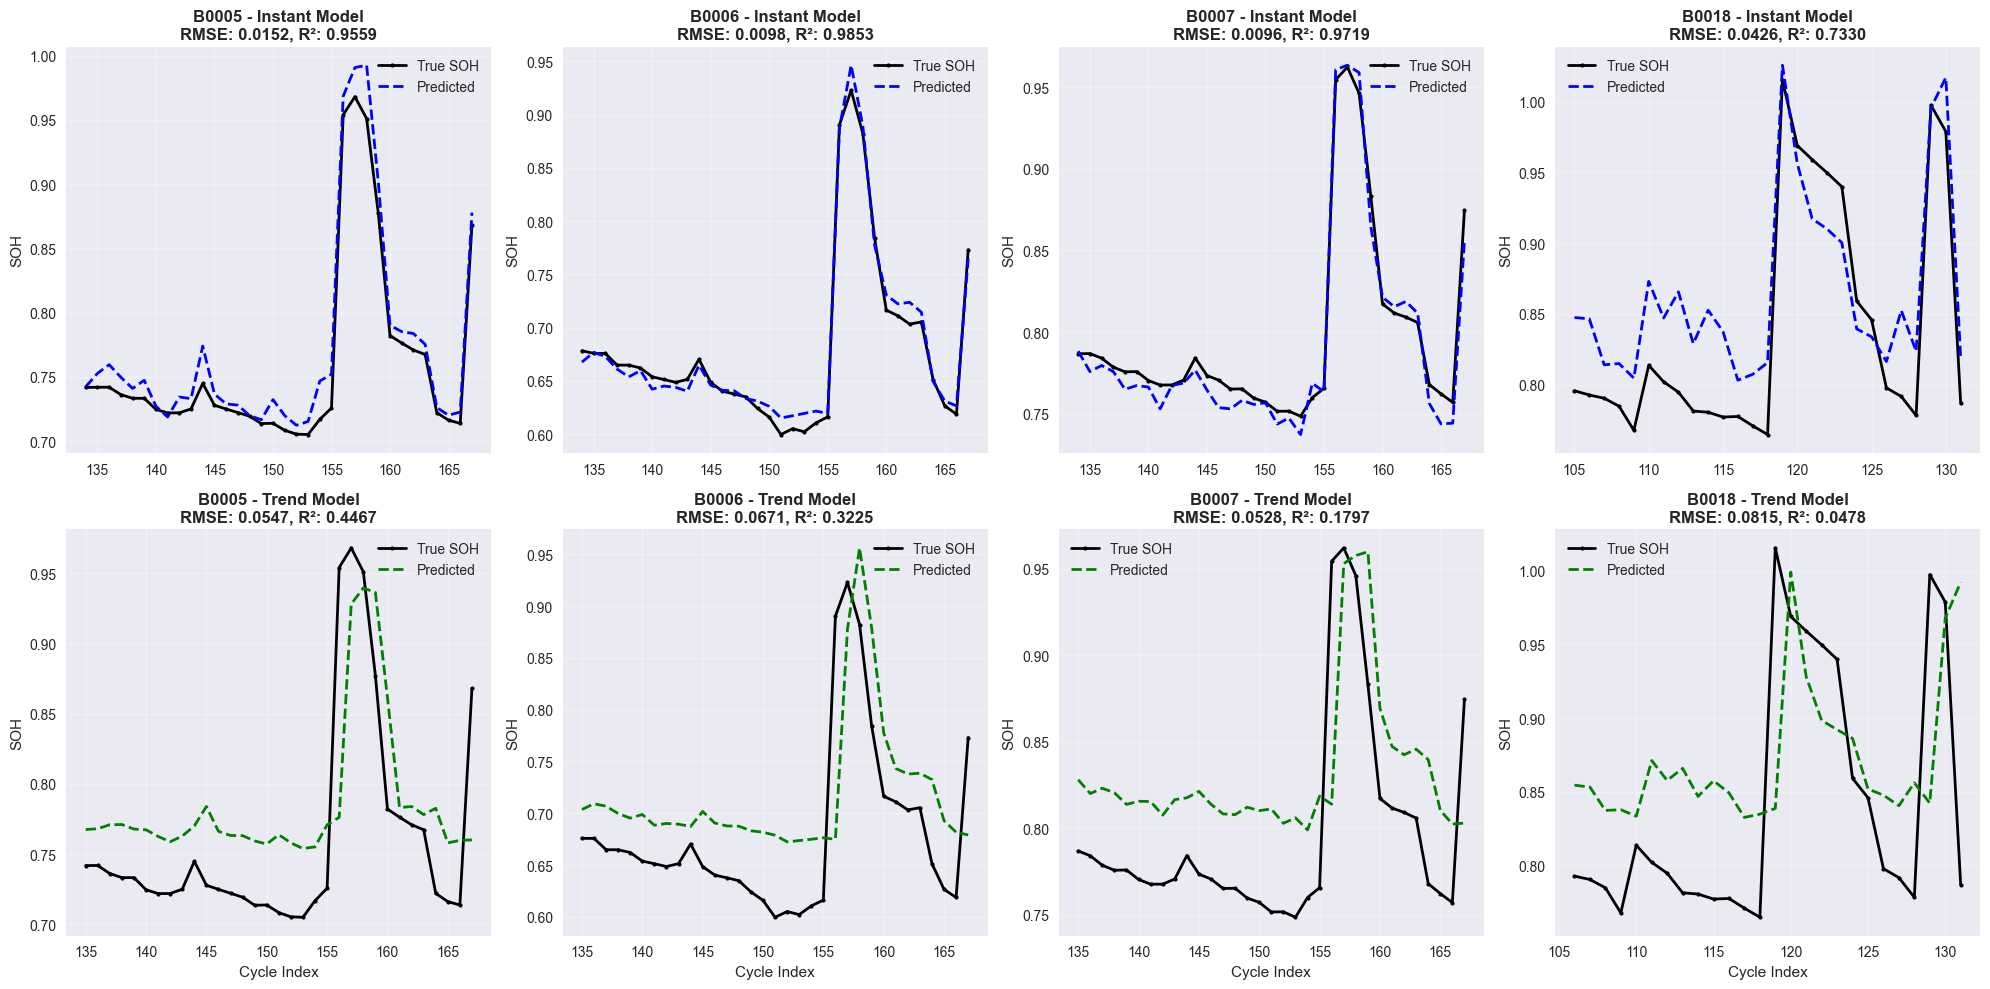

In [16]:
# 배터리별 예측 결과 시각화 (상하 배치)
fig, axes = plt.subplots(2, len(battery_ids), figsize=(5*len(battery_ids), 10))

for idx, battery_id in enumerate(battery_ids):
    r = results[battery_id]
    
    # Instant Model (위쪽)
    ax_instant = axes[0, idx] if len(battery_ids) > 1 else axes[0]
    instant_cycles = np.arange(r['instant']['split_idx'], r['total_cycles'])
    ax_instant.plot(instant_cycles, r['instant']['targets'], 
                    label="True SOH", marker="o", markersize=3, linewidth=2, color='black')
    ax_instant.plot(instant_cycles, r['instant']['preds'], 
                    label="Predicted", marker="x", markersize=3, linewidth=2, 
                    linestyle="--", color='blue')
    ax_instant.set_ylabel("SOH", fontsize=11)
    ax_instant.set_title(f"{battery_id} - Instant Model\nRMSE: {r['instant']['rmse']:.4f}, R²: {r['instant']['r2']:.4f}", 
                         fontsize=12, fontweight='bold')
    ax_instant.grid(True, alpha=0.3)
    ax_instant.legend(fontsize=10)
    
    # Trend Model (아래쪽)
    ax_trend = axes[1, idx] if len(battery_ids) > 1 else axes[1]
    trend_cycles = np.arange(r['trend']['split_idx'] + WINDOW_SIZE, r['total_cycles'])
    ax_trend.plot(trend_cycles, r['trend']['targets'], 
                  label="True SOH", marker="o", markersize=3, linewidth=2, color='black')
    ax_trend.plot(trend_cycles, r['trend']['preds'], 
                  label="Predicted", marker="x", markersize=3, linewidth=2, 
                  linestyle="--", color='green')
    ax_trend.set_ylabel("SOH", fontsize=11)
    ax_trend.set_xlabel("Cycle Index", fontsize=11)
    ax_trend.set_title(f"{battery_id} - Trend Model\nRMSE: {r['trend']['rmse']:.4f}, R²: {r['trend']['r2']:.4f}", 
                       fontsize=12, fontweight='bold')
    ax_trend.grid(True, alpha=0.3)
    ax_trend.legend(fontsize=10)

plt.tight_layout()
plt.show()

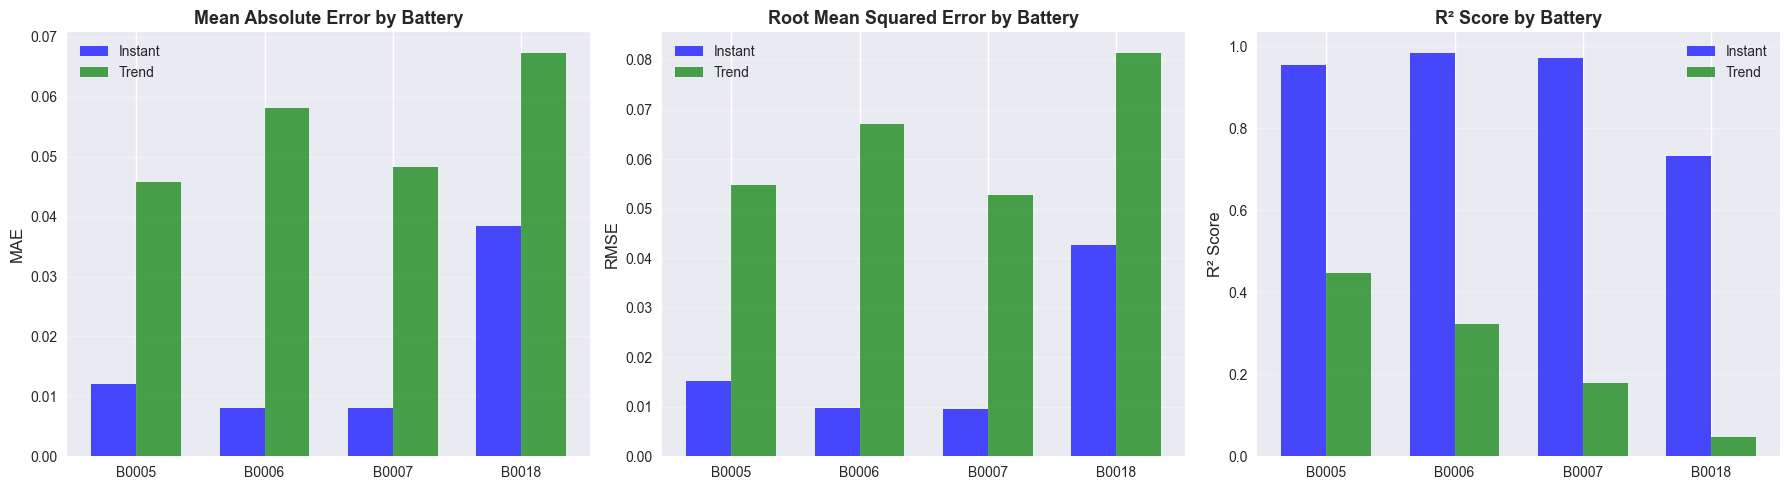

In [14]:
# 배터리별 성능 비교 막대 그래프
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(battery_ids))
width = 0.35

# MAE 비교
instant_maes = [results[bid]['instant']['mae'] for bid in battery_ids]
trend_maes = [results[bid]['trend']['mae'] for bid in battery_ids]
axes[0].bar(x - width/2, instant_maes, width, label='Instant', color='blue', alpha=0.7)
axes[0].bar(x + width/2, trend_maes, width, label='Trend', color='green', alpha=0.7)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error by Battery', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(battery_ids)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE 비교
instant_rmses = [results[bid]['instant']['rmse'] for bid in battery_ids]
trend_rmses = [results[bid]['trend']['rmse'] for bid in battery_ids]
axes[1].bar(x - width/2, instant_rmses, width, label='Instant', color='blue', alpha=0.7)
axes[1].bar(x + width/2, trend_rmses, width, label='Trend', color='green', alpha=0.7)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Root Mean Squared Error by Battery', fontsize=13, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(battery_ids)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# R² 비교
instant_r2s = [results[bid]['instant']['r2'] for bid in battery_ids]
trend_r2s = [results[bid]['trend']['r2'] for bid in battery_ids]
axes[2].bar(x - width/2, instant_r2s, width, label='Instant', color='blue', alpha=0.7)
axes[2].bar(x + width/2, trend_r2s, width, label='Trend', color='green', alpha=0.7)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score by Battery', fontsize=13, fontweight='bold')
axes[2].set_xticks(x)
axes[2].set_xticklabels(battery_ids)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [15]:
# 종합 결론
print("\n" + "=" * 90)
print("🎯 Battery Group 1 (B0005, B0006, B0007, B0018) - 종합 결론")
print("=" * 90)

print(f"\n【분석 대상】")
print(f"  • 배터리: {', '.join(battery_ids)}")
print(f"  • 총 사이클 수: {sum(r['total_cycles'] for r in results.values())}개")

print(f"\n【모델 특성】")
print(f"  • Instant Model: 개별 사이클 독립 예측")
print(f"  • Trend Model: {WINDOW_SIZE}개 사이클 윈도우 기반 예측")

print(f"\n【평균 성능】")
print(f"  ┌──────────┬──────────┬──────────┬──────────┐")
print(f"  │  Model   │   MAE    │   RMSE   │ R² Score │")
print(f"  ├──────────┼──────────┼──────────┼──────────┤")
print(f"  │ Instant  │  {avg_instant_mae:.4f}  │  {avg_instant_rmse:.4f}  │  {avg_instant_r2:.4f}  │")
print(f"  │ Trend    │  {avg_trend_mae:.4f}  │  {avg_trend_rmse:.4f}  │  {avg_trend_r2:.4f}  │")
print(f"  └──────────┴──────────┴──────────┴──────────┘")

print(f"\n【결론】")
if avg_trend_rmse < avg_instant_rmse:
    print(f"  ✅ Trend Model이 평균 {avg_improvement:.2f}% 더 우수한 성능을 보입니다.")
    print(f"  🎯 시계열 윈도우 방식이 배터리 열화 추세를 더 잘 학습합니다.")
else:
    print(f"  ✅ Instant Model이 평균 {-avg_improvement:.2f}% 더 우수한 성능을 보입니다.")
    print(f"  🎯 개별 사이클 방식이 즉시적인 상태 변화를 더 잘 포착합니다.")

# 배터리별 우수 모델
print(f"\n【배터리별 우수 모델】")
for battery_id in battery_ids:
    r = results[battery_id]
    if r['trend']['rmse'] < r['instant']['rmse']:
        winner = "Trend"
        improvement = ((r['instant']['rmse'] - r['trend']['rmse']) / r['instant']['rmse'] * 100)
    else:
        winner = "Instant"
        improvement = ((r['trend']['rmse'] - r['instant']['rmse']) / r['trend']['rmse'] * 100)
    print(f"  • {battery_id}: {winner} Model ({improvement:+.2f}% 개선)")

print("\n" + "=" * 90)
print("✨ 분석 완료!")
print("=" * 90)


🎯 Battery Group 1 (B0005, B0006, B0007, B0018) - 종합 결론

【분석 대상】
  • 배터리: B0005, B0006, B0007, B0018
  • 총 사이클 수: 636개

【모델 특성】
  • Instant Model: 개별 사이클 독립 예측
  • Trend Model: 3개 사이클 윈도우 기반 예측

【평균 성능】
  ┌──────────┬──────────┬──────────┬──────────┐
  │  Model   │   MAE    │   RMSE   │ R² Score │
  ├──────────┼──────────┼──────────┼──────────┤
  │ Instant  │  0.0166  │  0.0193  │  0.9115  │
  │ Trend    │  0.0549  │  0.0640  │  0.2492  │
  └──────────┴──────────┴──────────┴──────────┘

【결론】
  ✅ Instant Model이 평균 346.71% 더 우수한 성능을 보입니다.
  🎯 개별 사이클 방식이 즉시적인 상태 변화를 더 잘 포착합니다.

【배터리별 우수 모델】
  • B0005: Instant Model (+72.17% 개선)
  • B0006: Instant Model (+85.47% 개선)
  • B0007: Instant Model (+81.75% 개선)
  • B0018: Instant Model (+47.76% 개선)

✨ 분석 완료!
